In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from TCN.TCN.tcn import TCN_DimensionalityReduced

In [2]:
sns.set("notebook", "whitegrid")

# Data

In [69]:
class ECGDataset(Dataset):
    def __init__(self, data_dir, item_transform=None, target_transform=None, in_memory=True) -> None:
        self.data_dir = data_dir
        self.lengths = {}
        self.item_transform = item_transform
        self.target_transform = target_transform
        self.data = []
        self.in_memory = in_memory
        for _, _, files in os.walk(data_dir):
            for file in files:
                npzfile = np.load(data_dir + file)
                self.lengths[file] = len(npzfile["labels"])
                if in_memory:
                    hbs = npzfile["heartbeats"]
                    labels = npzfile["labels"]
                    self.data += zip(hbs, labels)
        
    def __len__(self) -> int:
        return sum(self.lengths.values())
    
    def __getitem__(self, idx):
        assert idx < self.__len__() # make sure we're not out of bounds
        if not self.in_memory:
            running_count = 0
            for file, length in self.lengths.items():
                if idx < running_count + length:
                    npzfile = np.load(self.data_dir + file)
                    hb = npzfile["heartbeats"][idx - running_count]
                    label = npzfile["labels"][idx - running_count]
                    if self.item_transform:
                        hb = self.item_transform(hb)
                    if self.target_transform:
                        label = self.target_transform(label)
                    return hb, label
                else:
                    running_count += length
        else:
            hb = self.data[idx][0]
            label = self.data[idx][1]
            hb = self.item_transform(hb) if self.item_transform else hb
            label = self.target_transform(label) if self.target_transform else label
            return hb, label
        # should never get here
        raise IndexError("Index out of bounds")

In [4]:
def one_hot_encode(label):
    possible_labels = ["N", "S", "V", "F", "Q"]
    # one hot encoding
    return torch.zeros(len(possible_labels)).scatter_(
        dim=0,
        index=torch.tensor(possible_labels.index(label)),
        value=1
    )

noise_frequencies = {
    "breathing": ([1/18, 1/12], [1/5, 1/3]) # breathing rate and impact
}

def noise_at_frequencies(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = np.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = np.random.uniform(freq_range[0], freq_range[1])
        amp = np.random.uniform(amp_range[0], amp_range[1])
        phase = np.random.uniform(0, 2 * np.pi)
        noise += amp * np.sin(2 * np.pi * freq * 1/fs + phase)
    return hb + noise

In [5]:
def noise_at_frequencies_tensor(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = torch.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = torch.distributions.uniform.Uniform(freq_range[0], freq_range[1]).sample()
        amp = torch.distributions.uniform.Uniform(amp_range[0], amp_range[1]).sample()
        phase = torch.distributions.uniform.Uniform(0, 2 * torch.pi).sample()
        noise += amp * torch.sin(2 * torch.pi * freq * 1/fs + phase)
    return hb.add(noise)

def z_normalise(hb):
    return (hb - hb.mean()) / hb.std()

def hb_transform(hb):
    hb = torch.from_numpy(hb)
    hb = noise_at_frequencies_tensor(hb, noise_frequencies)
    hb = z_normalise(hb)
    return hb

In [46]:
def label_transform(label, classes=np.array(["N", "S", "V", "F", "Q"])):
    return np.where(classes == label)[0][0]

In [70]:
train_set = ECGDataset("./data/heartbeats_train/", item_transform=hb_transform, target_transform=label_transform)
test_set = ECGDataset("./data/heartbeats_test/", target_transform=label_transform)

In [71]:
train_loader = DataLoader(train_set, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, pin_memory=True)

In [72]:
from fastai.data.core import DataLoaders

In [73]:
dls = DataLoaders(train_loader, test_loader)

In [75]:
for hb, label in train_loader:
    print(label.shape)
    break

torch.Size([1024])


# Model

In [10]:
import importlib
importlib.reload(sys.modules['TCN.TCN.tcn'])
from TCN.TCN.tcn import TCN_DimensionalityReduced

In [11]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, use_skip_connections=False):
        super(TCN, self).__init__()
        self.tcn = TCN_DimensionalityReduced(
            input_size,
            num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            use_skip_connections=use_skip_connections
        )
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()
    
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y = self.tcn(x)
        o = self.linear(y[:, :, -1])
        return o

# FastAI

In [82]:
from fastai.learner import Learner
from fastai.metrics import accuracy, Precision, Recall, F1Score, RocAuc
from fastai.callback.schedule import valley, slide, minimum, steep
import fastai.callback.schedule

In [14]:
torch.autograd.set_detect_anomaly(True)

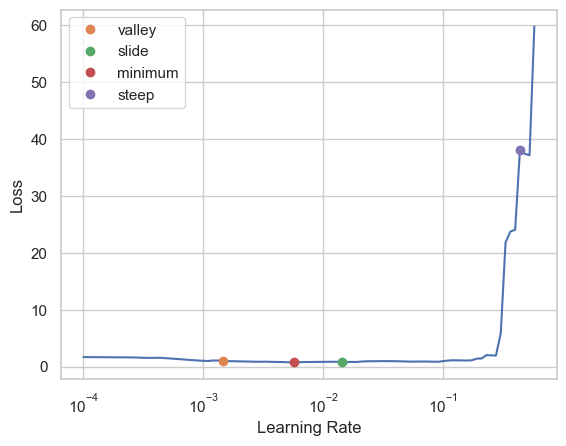

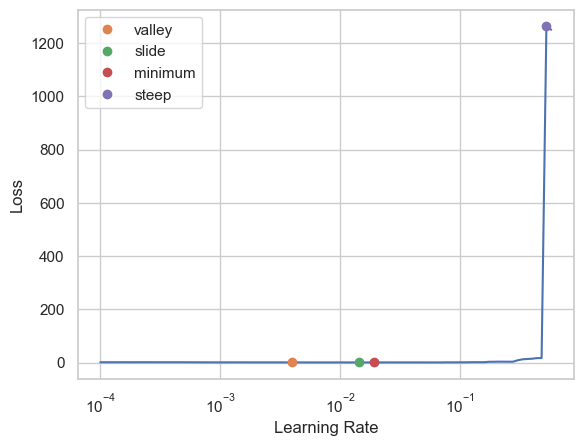

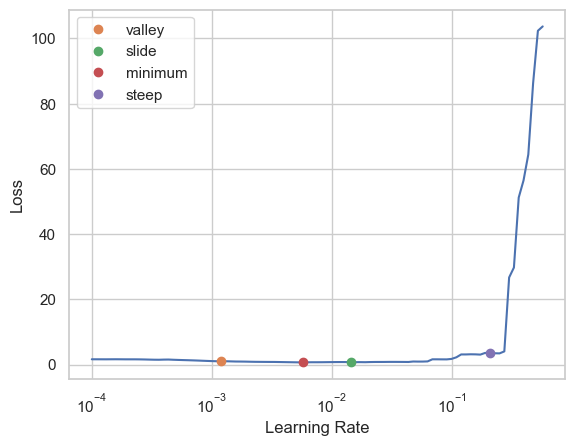

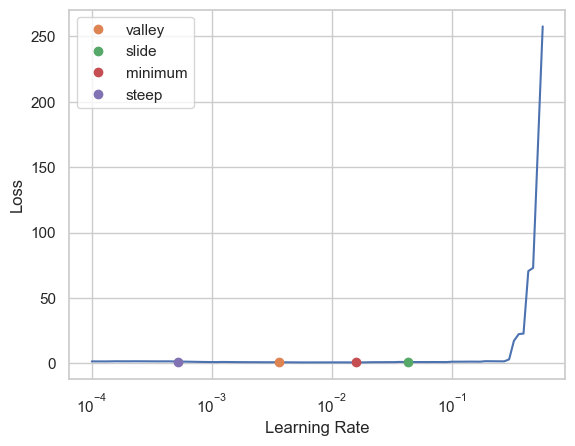

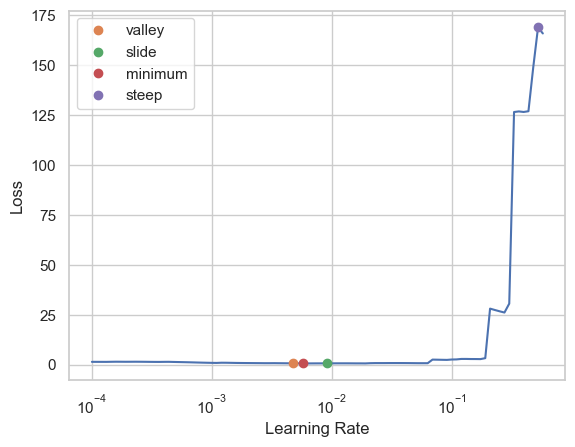

In [88]:
learners = []
suggestions = []
for wd in [1e-5, 3e-5, 1e-4, 3e-4, 0]:
    learn = Learner(
        dls=dls,
        model=TCN(360, 5, [32]*3, 32, 0.125, use_skip_connections=True).cuda(),
        loss_func=nn.CrossEntropyLoss(),
        metrics=[accuracy, Precision(average="macro"), Recall(average="macro"), F1Score(average="macro"), RocAuc(average="macro")],
        path="./models/tcn",
        wd=wd
    )
    suggestion = learn.lr_find(1e-4, 1.0, stop_div=False, suggest_funcs=[valley, slide, minimum, steep])
    suggestions.append(suggestion)
    # learn.recorder.plot_lr_find()
    learners.append(learn)

In [89]:
for suggestion in suggestions:
    print(suggestion)

SuggestedLRs(valley=0.0014454397605732083, slide=0.01445439737290144, minimum=0.0005754399579018354, steep=0.43651583790779114)
SuggestedLRs(valley=0.003981071524322033, slide=0.01445439737290144, minimum=0.0019054606556892395, steep=0.5248074531555176)
SuggestedLRs(valley=0.0012022644514217973, slide=0.01445439737290144, minimum=0.0005754399579018354, steep=0.2089296132326126)
SuggestedLRs(valley=0.00363078061491251, slide=0.04365158453583717, minimum=0.0015848932787775993, steep=0.0005248074885457754)
SuggestedLRs(valley=0.00478630093857646, slide=0.009120108559727669, minimum=0.0005754399579018354, steep=0.5248074531555176)


# Training

In [102]:
from sklearn.model_selection import StratifiedKFold

In [103]:
tcn_model = TCN(360, 5, [32]*3, 32, 0.125, use_skip_connections=True)
tcn_model

TCN(
  (tcn): TCN_DimensionalityReduced(
    (d_reduce): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
    (network): Sequential(
      (0): TemporalSkipBlock(
        (conv1): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(31,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.125, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(31,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.125, inplace=False)
        (net): Sequential(
          (0): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(31,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.125, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(31,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.125, inplace=False)
        )
        (relu): ReLU()
        (downsample): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
     